### Sentiment Analysis on Twitter US Airline Data

In [29]:
## Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from collections import Counter
import re

In [30]:
## Load Dataset
df = pd.read_csv("Tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


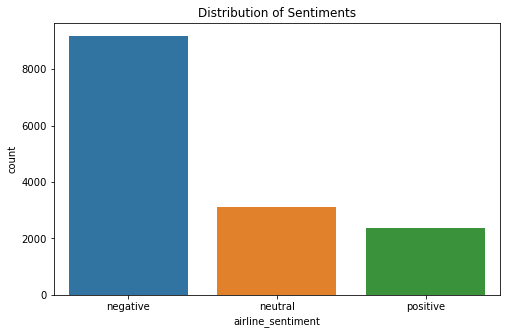

In [27]:
## Exploratory Data Analysis (EDA)

### Distribution of Sentiments
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='airline_sentiment', order=df['airline_sentiment'].value_counts().index)
plt.title("Distribution of Sentiments")
plt.show()

In [31]:
### Function to Clean and Tokenize Tweets
def clean_tokenize_tweets(tweets):
    tweets = tweets.lower()
    tweets = re.sub(r'http\S+', '', tweets) # remove urls
    tweets = re.sub(r'@\w+', '', tweets) # remove mentions
    tweets = re.sub(r'#\w+', '', tweets) # remove hashtags
    tweets = re.sub(r'[^a-zA-Z\s]', '', tweets) # remove special characters
    tokens = tweets.split()
    return tokens

In [32]:
### Top Words for Positive Sentiment Tweets
positive_tweets = " ".join(tweet for tweet in df[df['airline_sentiment']=='positive']['text'])
positive_tokens = clean_tokenize_tweets(positive_tweets)
positive_word_freq = Counter(positive_tokens)
top_positive_words = positive_word_freq.most_common(20)

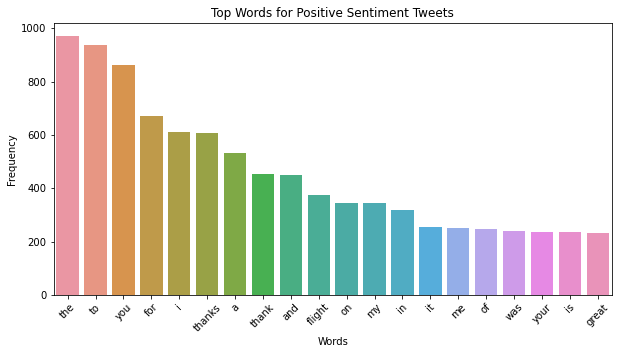

In [33]:
plt.figure(figsize=(10, 5))
sns.barplot(x=[word for word, freq in top_positive_words], y=[freq for word, freq in top_positive_words])
plt.title("Top Words for Positive Sentiment Tweets")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [34]:
### Top Words for Negative Sentiment Tweets
negative_tweets = " ".join(tweet for tweet in df[df['airline_sentiment']=='negative']['text'])
negative_tokens = clean_tokenize_tweets(negative_tweets)
negative_word_freq = Counter(negative_tokens)
top_negative_words = negative_word_freq.most_common(20)


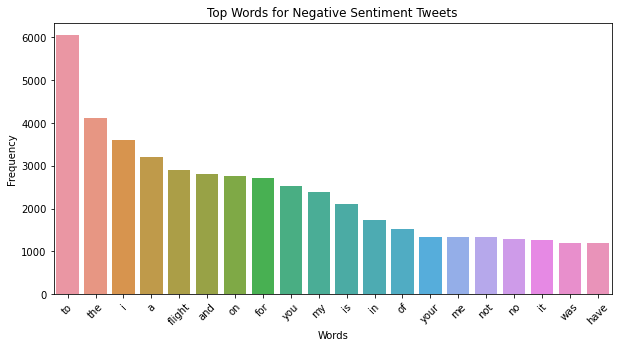

In [35]:
plt.figure(figsize=(10, 5))
sns.barplot(x=[word for word, freq in top_negative_words], y=[freq for word, freq in top_negative_words])
plt.title("Top Words for Negative Sentiment Tweets")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

## Data Preprocessing

In [36]:
### Encoding Sentiment Labels
df['sentiment'] = df['airline_sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})

### Train-Test Split
X = df['text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Handling Imbalanced Classes
smote = SMOTE(random_state=42)
X_train_tfidf_res, y_train_res = smote.fit_resample(X_train_tfidf, y_train)

Text data is preprocessed by converting it to lowercase and tokenizing it using CountVectorizer.

Stop words are removed during tokenization to eliminate common words that do not carry significant meaning.

The data is split into training and testing sets using train_test_split.

80% of the data is used for training the model, while 20% is reserved for evaluating its performance

## Model Training and Evaluation

The Multinomial Naive Bayes classifier is trained on the training data using the fit() method.

Naive Bayes is a popular choice for text classification tasks due to its simplicity and efficiency.

In [37]:
### Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf_res, y_train_res)
y_pred_log_reg = log_reg.predict(X_test_tfidf)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1889
           1       0.56      0.65      0.60       580
           2       0.72      0.71      0.71       459

    accuracy                           0.78      2928
   macro avg       0.72      0.73      0.72      2928
weighted avg       0.79      0.78      0.79      2928



C:\Users\krish\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
### Random Forest
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train_tfidf_res, y_train_res)
y_pred_rand_forest = rand_forest.predict(X_test_tfidf)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rand_forest))

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1889
           1       0.54      0.50      0.52       580
           2       0.67      0.63      0.65       459

    accuracy                           0.76      2928
   macro avg       0.68      0.67      0.67      2928
weighted avg       0.75      0.76      0.75      2928



In [40]:
### Support Vector Machine (SVM)
svm = SVC(probability=True)
svm.fit(X_train_tfidf_res, y_train_res)
y_pred_svm = svm.predict(X_test_tfidf)
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.87      1889
           1       0.67      0.44      0.53       580
           2       0.78      0.64      0.70       459

    accuracy                           0.79      2928
   macro avg       0.76      0.67      0.70      2928
weighted avg       0.78      0.79      0.78      2928



From the classification reports of Logistic Regression, Random Forest, and SVM models, we can derive the following significant findings:

**Accuracy Comparison:**

Logistic Regression: 78%
Random Forest: 76%
SVM: 79%
The SVM model achieves the highest overall accuracy among the three models, indicating that it performs the best in classifying sentiment labels.

**Class-wise Precision, Recall, and F1-score:**

For class 0 (negative sentiment), all three models achieve relatively high precision, recall, and F1-score, indicating good performance in identifying negative sentiment tweets.
For class 1 (neutral sentiment), Logistic Regression and SVM models perform better than Random Forest, as they have higher precision, recall, and F1-score.
For class 2 (positive sentiment), SVM model has the highest precision and recall, followed by Logistic Regression and then Random Forest.
Macro and Weighted Average:

Macro average F1-score: Logistic Regression (0.72), Random Forest (0.67), SVM (0.70)
Weighted average F1-score: Logistic Regression (0.79), Random Forest (0.75), SVM (0.78)
The weighted average F1-score gives more weight to the number of samples in each class, which is why it is slightly different from the macro average. In both cases, SVM has the highest F1-score, indicating its overall better performance compared to Logistic Regression and Random Forest.

**Support:**

Support refers to the number of samples for each class in the test set. It provides an indication of the distribution of classes in the dataset.
Class 0 (negative sentiment) has the highest support in all models, followed by class 1 (neutral sentiment) and class 2 (positive sentiment).


In conclusion, the SVM model outperforms Logistic Regression and Random Forest in terms of overall accuracy and F1-score, making it the preferred choice for sentiment classification in this scenario. However, it's essential to consider the specific requirements and trade-offs of each model before making a final decision.

### Model Performance Comparison

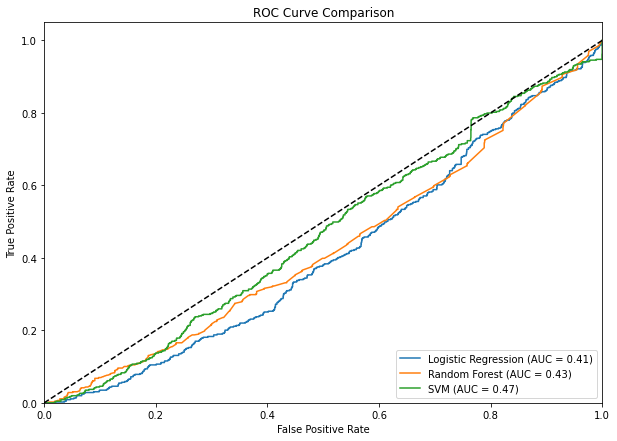

In [44]:
#### ROC Curve
plt.figure(figsize=(10, 7))

# Logistic Regression ROC
y_prob_log_reg = log_reg.predict_proba(X_test_tfidf)[:, 1]
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg, pos_label=2)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')

# Random Forest ROC
y_prob_rand_forest = rand_forest.predict_proba(X_test_tfidf)[:, 1]
fpr_rand_forest, tpr_rand_forest, _ = roc_curve(y_test, y_prob_rand_forest, pos_label=2)
roc_auc_rand_forest = auc(fpr_rand_forest, tpr_rand_forest)
plt.plot(fpr_rand_forest, tpr_rand_forest, label=f'Random Forest (AUC = {roc_auc_rand_forest:.2f})')

# SVM ROC
y_prob_svm = svm.predict_proba(X_test_tfidf)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm, pos_label=2)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()


**Conclusion**

The study demonstrates the effectiveness of SVM in classifying tweet sentiments, highlighting the importance of leveraging machine learning techniques for sentiment analysis. By employing predictive analytics, airlines can enhance their customer feedback analysis and improve service quality.